In [1]:
import numpy as np
from brian2 import *
from random import randrange
from collections import Counter
import math

In [2]:
def make_poisson_pattern_current(N , patterns , duration , delta_time , possibility):
    l = 0
    for i in patterns:
        if max(i) > l:
            l = max(i)
            
    which_neuron = []
    spike_time = []
    pattern_time = []
    which_pattern = []
    
    pre = 0
    for i in range (int(duration/ms /(delta_time/ms *l))):
        base = i*l
        choice = np.random.choice([1,0],p=[possibility , 1-possibility])
        
        if pre == 1:
            choice = 0
            pre = 0
            
        if choice == 1:
            pre = 1
            pattern_time.append(base * delta_time/ms)
            pattern_number = randrange(len(patterns))
            which_pattern.append(pattern_number)
            
        for j in range(N):
            if choice == 0:
                rand = randrange(0,l+1)
                if rand == 0:
                    continue
                spike_time.append((base + rand)*(delta_time/ms) * ms)
                which_neuron.append(j)
                
            if choice == 1:
                if patterns[pattern_number][j] != 0:
                    which_neuron.append(j)
                    spike_time.append((base + patterns[pattern_number][j])*(delta_time/ms)* ms)
    
    return which_neuron , spike_time , pattern_time , which_pattern , l*delta_time/ms

In [38]:
which_neuron , spike_time , pattern_time , which_pattern , l= make_poisson_pattern_current(10 , [[2,6,2,6,2,6,2,6,2,6],[7,7,7,7,7,7,7,7,7,7,]] , 20*ms , 1*ms , 0.6)

In [42]:
pattern_time

[0.0]

In [43]:
which_pattern

[0]

In [3]:
def pulse_input_current_generator(max_I,delta_time,duration,possibility):
    output = TimedArray([np.random.choice([max_I,0],p=[possibility,1 - possibility]) * namp for i in range(int(duration/delta_time))],delta_time)
    return output

In [56]:
amp

amp

In [80]:
def simulate (duration = 200*ms , Apre=2 , I_1 = 2 * Mohm , p_1 = 0.1 , I_2 = 2 * Mohm , p_2 = 0.1 , p_pattern = 0.40 , tau_pre = 12*ms 
              , u_rest_post = -70 * mV, tau_post_1 = 14 * ms , threshold_post = -55 * mV , Resistance_post_1 = 8 * Mohm
              , tau_post_2 = 11 * ms , Resistance_post_2 = 6 * Mohm):
    
    start_scope()
    delta_time = 0.1 * ms
    wmax = 1
    Apost = -Apre * tau_pre / tau_post_1 * 1.04
    
    which_neuron , spike_time , pattern_time , which_pattern , l= make_poisson_pattern_current(10 , [[7,0,4,4,9,1,0,5,4,2],[6,4,8,2,7,5,9,1,3,5]] , duration , delta_time , p_pattern)
    pre = SpikeGeneratorGroup(10, which_neuron, spike_time)
    
    input_current_post_1 = pulse_input_current_generator(I_1 , delta_time , duration , p_1)
    input_current_post_2 = pulse_input_current_generator(I_2 , delta_time , duration , p_2)
    
    eqs_post = '''
        du/dt = -(u-u_rest)/tau + Resistance * input_current_post_1(t)/tau : volt
        tau : second
        u_rest : volt
        Resistance : ohm
    '''
    post = NeuronGroup(2,eqs_post,threshold='u>threshold_post', reset='u=u_rest_post',method='linear')
    
    n1 = post[0]
    n1.u = u_rest_post
    n1.tau = tau_post_1
    n1.u_rest = u_rest_post
    n1.Resistance = Resistance_post_1
    
    n2 = post[1]
    n2.u = u_rest_post
    n2.tau = tau_post_2
    n2.u_rest = u_rest_post
    n2.Resistance = Resistance_post_2
    
    syn = Synapses (pre , post ,
             '''
             w : 1
             dapre/dt = -apre/tau_pre : 1 (clock-driven)
             dapost/dt = -apost/tau_post : 1 (clock-driven)
             ''' ,
             on_pre= '''
             u_post += w*5 * mV
             apre += Apre
             w = clip(w+apost, 0, wmax) 
             ''' ,
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')
    
    syn.connect(p=1)
    
    syn.w = [0.4 + random()*0.2 for i in range(20)]
    
    u_mon = StateMonitor(post , 'u' , record = True)
    M = StateMonitor(syn, ['w', 'apre', 'apost'], record=True)
    s1 = SpikeMonitor(post)
    s2 = SpikeMonitor(pre)
    
    run(duration)
    
    figure(figsize=(14, 14))
    subplot(611)
#     plot(u_mon.t/ms , u_mon.u[0]/mV, label = '0')
#     plot(u_mon.t/ms , u_mon.u[1]/mV, label = '1')
#     for i in range (len(pattern_time)):
#         if which_pattern[i] == 0:
#             axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
#         else:
#             axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
#     for i in range(2):
    plot(M.t/ms, M.apre[1], label='apre '+str(0))
    plot(M.t/ms, M.apost[1], label='apost '+str(0))
    plt.axhline(color='red')
        
#     for i in range (len(pattern_time)):
#         if which_pattern[i] == 0:
#             axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
#         else:
#             axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
    legend()
    subplot(612)
#     post_1_spike_times = sorted(list(flatten([list(list(s1.all_values()['t'][0])/ms)])))
#     post_2_spike_times = sorted(list(flatten([list(list(s1.all_values()['t'][1])/ms)])))
    
#     plot(list(Counter(post_1_spike_times).keys()) ,list(Counter(post_1_spike_times).values()),label = 'post1')
#     plot(list(Counter(post_2_spike_times).keys()) ,list(Counter(post_2_spike_times).values()),label = 'post2')
#     for i in range(10):
#     plot(M.t/ms, M.w[0], label='w')
#     legend(loc='best')
#     xlabel('Time (ms)')
#     ylabel('W (mV)')
    plot(u_mon.t/ms , u_mon.u[0]/mV, label = '0')
#     plot(u_mon.t/ms , u_mon.u[1]/mV, label = '1')
    legend()
#     plot(u_mon.t/ms , u_mon.u[4], label = '1')
    for i in range (len(pattern_time)):
#         if pattern_time[i] < duration/ms - last:
#             continue
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
    subplot(613)
    last = 2 * int(duration/ms / 10)
    if last > 100:
        last = 100
    plot(u_mon.t[-last*10:-1]/ms , u_mon.u[0][-last*10:-1]/mV, label = '0')
    plot(u_mon.t[-last*10:-1]/ms , u_mon.u[1][-last*10:-1]/mV, label = '1')
    for i in range (len(pattern_time)):
        if pattern_time[i] < duration/ms - last:
            continue
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
    subplot(614)
    plot(M.t[-last*10:-1]/ms, M.w[1][-last*10:-1], label='w_0')
#     plot(M.t[-last*10:-1]/ms, M.w[10][-last*10:-1], label='w_1')
    legend()
#     plot(M.t/ms, M.w[2], label='w')
#     plot(M.t/ms, M.w[3], label='w')
#     plot(M.t/ms, M.w[4], label='w')
    subplot(615)
    plot(s1.t/ms,s1.i, 'ok', ms=1)
    for i in range (len(pattern_time)):
#         if pattern_time[i] < duration/ms - last:
#             continue
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
    subplot(616)
    plot(s2.t/ms,s2.i, 'ok', ms=1)
    for i in range (len(pattern_time)):
#         if pattern_time[i] < duration/ms - last:
#             continue
        if which_pattern[i] == 0:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='red')
        else:
            axvspan(pattern_time[i] , pattern_time[i]+l, alpha=0.2, color='blue')
#     return s1
    return M , s1 , s2 , pattern_time , which_pattern , which_neuron , spike_time , u_mon

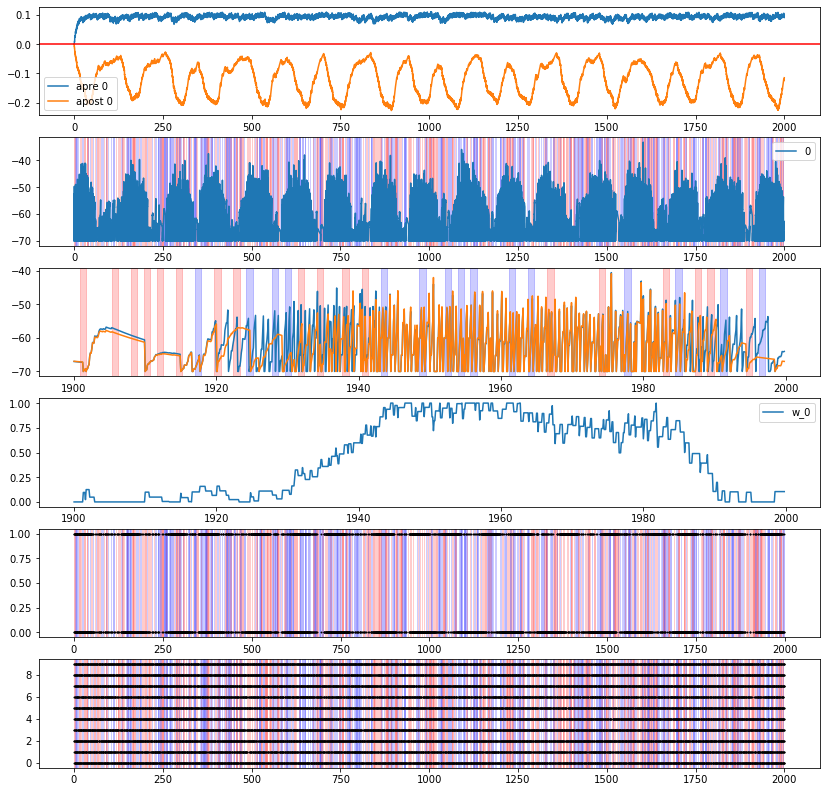

In [106]:
M , s1 , s2 , pattern_time , which_pattern , which_neuron , spike_time , u_mon = simulate(duration = 2000*ms , Apre=0.01
              , I_1 = 1 * Mohm , p_1 = 0.05 , I_2 = 0* Mohm , p_2 = 0.07 , p_pattern = 0.4 , tau_pre = 9*ms 
              , u_rest_post = -70 * mV, tau_post_1 = 14* ms , threshold_post = -55 * mV , Resistance_post_1 = 20 * Mohm
              , tau_post_2 = 15 * ms , Resistance_post_2 = 13 * Mohm)

In [24]:
len(M.w)

20

In [258]:
sorted([x/ms for x in s1.all_values()['t'][0]])

[2.0,
 2.1,
 2.2,
 2.3,
 2.4000000000000004,
 2.5,
 2.6,
 2.7,
 2.8,
 2.9000000000000004,
 4.0,
 4.1000000000000005,
 4.2,
 4.3,
 4.4,
 4.5,
 4.6,
 4.7,
 4.800000000000001,
 4.8999999999999995,
 6.0,
 6.1000000000000005,
 6.2,
 6.3,
 6.4,
 6.5,
 6.6,
 6.7,
 6.800000000000001,
 6.9,
 14.0,
 14.100000000000001,
 14.200000000000001,
 14.3,
 14.4,
 14.5,
 14.6,
 14.700000000000001,
 14.8,
 14.9,
 21.0,
 21.1,
 21.2,
 21.3,
 21.400000000000002,
 21.5,
 21.6,
 21.7,
 21.8,
 21.9,
 28.099999999999998,
 30.0,
 30.1,
 30.2,
 30.3,
 30.4,
 30.500000000000004,
 30.6,
 30.7,
 30.8,
 30.9,
 31.0,
 31.1,
 31.200000000000003,
 31.3,
 31.400000000000002,
 31.5,
 31.6,
 31.7,
 31.8,
 31.900000000000006,
 42.1,
 46.0,
 46.1,
 46.2,
 46.3,
 46.400000000000006,
 46.5,
 46.6,
 46.7,
 46.8,
 46.900000000000006]

In [254]:
pattern_time

[7.0, 21.0, 28.0, 35.0]

In [229]:
sorted([x/ms for x,y in zip(spike_time,which_neuron) if y==0])

[2.0, 9.0]

In [30]:
sorted([x/ms for x in s1.all_values()['t'][0]])

[5.0,
 5.1000000000000005,
 5.2,
 5.3,
 5.4,
 5.5,
 5.6,
 5.7,
 5.800000000000001,
 5.8999999999999995,
 11.0,
 11.1,
 11.2,
 11.3,
 11.4,
 11.5,
 11.600000000000001,
 11.7,
 11.799999999999999,
 11.9,
 13.0,
 13.1,
 13.2,
 13.3,
 13.4,
 13.5,
 13.600000000000001,
 13.7,
 13.8,
 13.9,
 21.0,
 21.1,
 21.2,
 21.3,
 21.400000000000002,
 21.5,
 21.6,
 21.7,
 21.8,
 21.9,
 25.0,
 25.1,
 25.2,
 25.3,
 25.400000000000002,
 25.5,
 25.6,
 25.7,
 25.8,
 25.900000000000002,
 30.0,
 30.1,
 30.2,
 30.3,
 30.4,
 30.500000000000004,
 30.6,
 30.7,
 30.8,
 30.9,
 31.0,
 31.1,
 31.200000000000003,
 31.3,
 31.400000000000002,
 31.5,
 31.6,
 31.7,
 31.8,
 31.900000000000006,
 40.0,
 40.1,
 40.199999999999996,
 40.300000000000004,
 40.400000000000006,
 40.5,
 40.6,
 40.699999999999996,
 40.800000000000004,
 40.9,
 45.00000000000001,
 45.1,
 45.2,
 45.3,
 45.4,
 45.5,
 45.6,
 45.7,
 45.8,
 45.900000000000006,
 49.0,
 49.1,
 49.2,
 49.300000000000004,
 49.4,
 49.5,
 49.6,
 49.7,
 49.800000000000004,
 49.9,
 

In [207]:
s2.all_values()

{'t': {0: array([0.002, 0.634, 0.637, 0.644, 0.647, 0.656, 0.658, 0.664, 0.669,
         0.676, 0.677, 0.688, 0.689, 0.693, 0.697, 0.701, 0.708, 0.71 ,
         0.715, 0.718, 0.724, 0.726, 0.729, 0.736, 0.629, 0.624, 0.62 ,
         0.614, 0.513, 0.52 , 0.523, 0.528, 0.531, 0.536, 0.54 , 0.544,
         0.548, 0.553, 0.557, 0.737, 0.564, 0.569, 0.573, 0.577, 0.582,
         0.587, 0.59 , 0.593, 0.6  , 0.604, 0.606, 0.612, 0.566, 0.512,
         0.744, 0.752, 0.881, 0.885, 0.89 , 0.894, 0.9  , 0.901, 0.905,
         0.909, 0.919, 0.922, 0.925, 0.94 , 0.948, 0.949, 0.953, 0.96 ,
         0.963, 0.965, 0.969, 0.976, 0.979, 0.984, 0.985, 0.878, 0.873,
         0.872, 0.868, 0.753, 0.758, 0.762, 0.767, 0.78 , 0.782, 0.788,
         0.789, 0.795, 0.8  , 0.803, 0.745, 0.806, 0.815, 0.818, 0.828,
         0.834, 0.84 , 0.842, 0.848, 0.849, 0.853, 0.86 , 0.862, 0.811,
         0.989, 0.506, 0.497, 0.134, 0.14 , 0.143, 0.147, 0.156, 0.16 ,
         0.161, 0.168, 0.172, 0.174, 0.177, 0.187, 0.191

In [179]:
M.w[0][61]-M.w[0][60]

-0.03969859320995961

In [180]:
M.apost[0][61]

-0.03969859320995966

In [167]:
s2.all_values()

{'t': {0: array([6.]) * msecond}}

In [169]:
M.apre[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01      , 0.00992883, 0.00985816, 0.00978799,
       0.00971833, 0.00964916, 0.00958048, 0.00951229, 0.00944459,
       0.00937737, 0.00931063, 0.00924436, 0.00917856, 0.00911

In [170]:
M.apre[1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01      , 0.00992883, 0.00985816, 0.00978799,
       0.00971833, 0.00964916, 0.00958048, 0.00951229, 0.00944459,
       0.00937737, 0.00931063, 0.00924436, 0.00917856, 0.00911

In [102]:
a

[5.0,
 5.1000000000000005,
 5.2,
 5.3,
 5.4,
 5.5,
 5.6,
 5.7,
 5.800000000000001,
 5.8999999999999995,
 17.0,
 17.1,
 17.2,
 17.3,
 17.400000000000002,
 17.5,
 17.6,
 17.7,
 17.8,
 17.9,
 19.0,
 19.1,
 19.200000000000003,
 19.3,
 19.4,
 19.5,
 19.599999999999998,
 19.700000000000003,
 19.8,
 19.900000000000002,
 26.0,
 26.1,
 26.2,
 26.3,
 26.4,
 26.500000000000004,
 26.6,
 26.7,
 26.8,
 26.9,
 27.0,
 27.1,
 27.200000000000003,
 27.3,
 27.4,
 27.5,
 27.6,
 27.700000000000003,
 27.8,
 27.900000000000002,
 31.0,
 31.1,
 31.200000000000003,
 31.3,
 31.400000000000002,
 31.5,
 31.6,
 31.7,
 31.8,
 31.900000000000006,
 32.0,
 32.1,
 32.199999999999996,
 32.300000000000004,
 32.4,
 32.5,
 32.6,
 32.699999999999996,
 32.800000000000004,
 32.9,
 38.0,
 38.1,
 38.2,
 38.3,
 38.400000000000006,
 38.5,
 38.6,
 38.7,
 38.8,
 38.900000000000006,
 40.0,
 40.1,
 40.199999999999996,
 40.300000000000004,
 40.400000000000006,
 40.5,
 40.6,
 40.699999999999996,
 40.800000000000004,
 40.9,
 47.0,
 47.1,


In [103]:
Counter(a)

Counter({5.0: 1,
         5.1000000000000005: 1,
         5.2: 1,
         5.3: 1,
         5.4: 1,
         5.5: 1,
         5.6: 1,
         5.7: 1,
         5.800000000000001: 1,
         5.8999999999999995: 1,
         17.0: 1,
         17.1: 1,
         17.2: 1,
         17.3: 1,
         17.400000000000002: 1,
         17.5: 1,
         17.6: 1,
         17.7: 1,
         17.8: 1,
         17.9: 1,
         19.0: 1,
         19.1: 1,
         19.200000000000003: 1,
         19.3: 1,
         19.4: 1,
         19.5: 1,
         19.599999999999998: 1,
         19.700000000000003: 1,
         19.8: 1,
         19.900000000000002: 1,
         26.0: 1,
         26.1: 1,
         26.2: 1,
         26.3: 1,
         26.4: 1,
         26.500000000000004: 1,
         26.6: 1,
         26.7: 1,
         26.8: 1,
         26.9: 1,
         27.0: 1,
         27.1: 1,
         27.200000000000003: 1,
         27.3: 1,
         27.4: 1,
         27.5: 1,
         27.6: 1,
         27.7000000000

In [96]:
a

[7.0,
 7.0,
 7.1000000000000005,
 7.1000000000000005,
 7.2,
 7.2,
 7.3,
 7.3,
 7.4,
 7.4,
 7.5,
 7.5,
 7.6,
 7.6,
 7.7,
 7.7,
 7.800000000000001,
 7.800000000000001,
 7.9,
 7.9,
 10.0,
 10.0,
 10.100000000000001,
 10.100000000000001,
 10.200000000000001,
 10.200000000000001,
 10.3,
 10.3,
 10.4,
 10.4,
 10.5,
 10.5,
 10.6,
 10.6,
 10.700000000000001,
 10.700000000000001,
 10.8,
 10.8,
 10.9,
 10.9,
 25.0,
 25.0,
 25.1,
 25.1,
 25.2,
 25.2,
 25.3,
 25.3,
 25.400000000000002,
 25.400000000000002,
 25.5,
 25.5,
 25.6,
 25.6,
 25.7,
 25.7,
 25.8,
 25.8,
 25.900000000000002,
 25.900000000000002,
 26.0,
 26.0,
 26.1,
 26.1,
 26.2,
 26.2,
 26.3,
 26.3,
 26.4,
 26.4,
 26.500000000000004,
 26.500000000000004,
 26.6,
 26.6,
 26.7,
 26.7,
 26.8,
 26.8,
 26.9,
 26.9,
 29.0,
 29.0,
 29.1,
 29.1,
 29.2,
 29.2,
 29.300000000000004,
 29.300000000000004,
 29.400000000000002,
 29.400000000000002,
 29.5,
 29.5,
 29.6,
 29.6,
 29.7,
 29.7,
 29.8,
 29.8,
 29.900000000000002,
 29.900000000000002,
 34.0,
 34

In [95]:
list(Counter(a).keys())

[7.0,
 7.1000000000000005,
 7.2,
 7.3,
 7.4,
 7.5,
 7.6,
 7.7,
 7.800000000000001,
 7.9,
 10.0,
 10.100000000000001,
 10.200000000000001,
 10.3,
 10.4,
 10.5,
 10.6,
 10.700000000000001,
 10.8,
 10.9,
 25.0,
 25.1,
 25.2,
 25.3,
 25.400000000000002,
 25.5,
 25.6,
 25.7,
 25.8,
 25.900000000000002,
 26.0,
 26.1,
 26.2,
 26.3,
 26.4,
 26.500000000000004,
 26.6,
 26.7,
 26.8,
 26.9,
 29.0,
 29.1,
 29.2,
 29.300000000000004,
 29.400000000000002,
 29.5,
 29.6,
 29.7,
 29.8,
 29.900000000000002,
 34.0,
 34.099999999999994,
 34.2,
 34.300000000000004,
 34.4,
 34.5,
 34.6,
 34.7,
 34.800000000000004,
 34.9,
 35.0,
 35.1,
 35.2,
 35.300000000000004,
 35.4,
 35.5,
 35.6,
 35.7,
 35.8,
 35.9,
 38.0,
 38.1,
 38.2,
 38.3,
 38.400000000000006,
 38.5,
 38.6,
 38.7,
 38.8,
 38.900000000000006,
 39.0,
 39.1,
 39.199999999999996,
 39.300000000000004,
 39.400000000000006,
 39.5,
 39.6,
 39.699999999999996,
 39.800000000000004,
 39.900000000000006,
 42.0,
 42.1,
 42.2,
 42.300000000000004,
 42.4,
 42.5,
 

In [98]:
list(Counter(a).values())

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [88]:
len(a)

1540

In [92]:
s1.all_values()['t'].get(1)

array([333.1, 395.1, 303. , 332.8, 247.5, 333.2, 314.6, 395.2, 367.6,
       366.5, 249.5, 247.6, 284.9, 395.3, 387.4, 247.3, 314. , 314.7,
       332.7, 367.3, 284.5, 247.2, 395.4, 247.4, 284.8, 367.4, 249.2,
       314.2, 387.6, 303.1, 387.7, 249.1, 367.5, 284.6, 314.3, 249. ,
       387.8, 333. , 314.5, 284.7, 249.3, 387.9, 366.4, 314.1, 314.4,
       387.5, 247.8, 249.4, 332.9, 395. , 247.7, 247.9, 314.8, 373.5,
       292.9, 245.1, 332.2, 331.4, 292.3, 245. , 397.3, 367. , 292.7,
       239.9, 331.5, 397.4, 332.1, 239.8, 292.4, 397.2, 397.5, 331.6,
       332. , 239.6, 397.6, 366.9, 331.7, 239.5, 397.7, 292.5, 239.4,
       331.9, 331.8, 397.8, 239.3, 239.7, 247.1, 366.7, 331.3, 395.5,
       332.6, 247. , 292. , 249.6, 395.6, 245.9, 367.2, 332.5, 245.8,
       395.7, 331. , 366.6, 245.7, 245.2, 292.1, 245.6, 331.1, 332.4,
       395.9, 245.5, 292.8, 367.1, 331.2, 245.4, 397. , 292.2, 332.3,
       245.3, 397.1, 395.8, 314.9, 249.8, 333.3, 366. , 378.3, 275.3,
       351.4, 307.5,

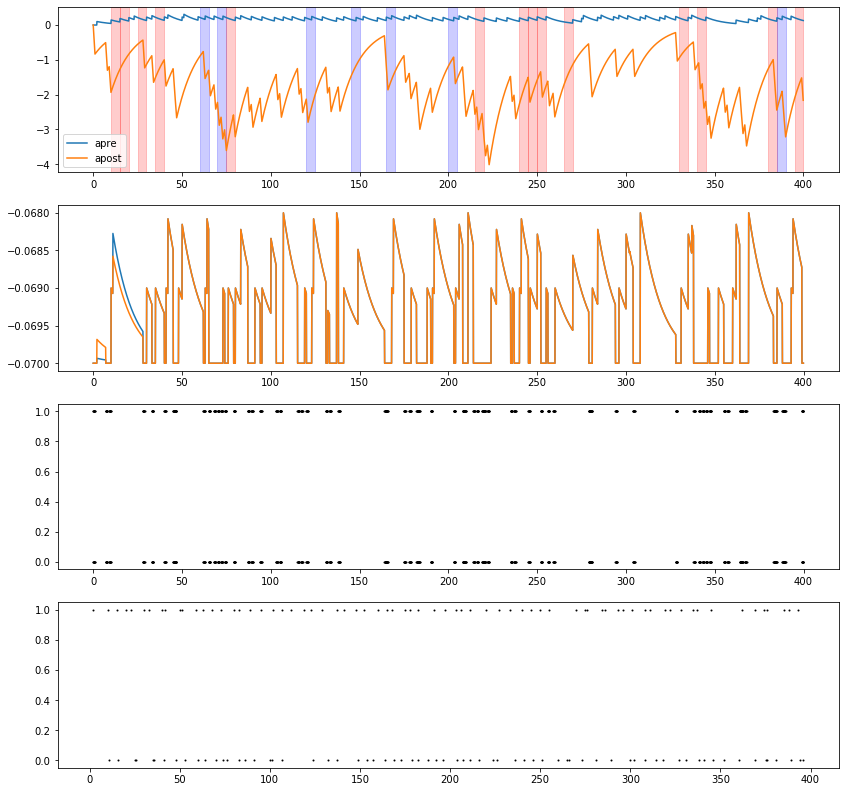

In [79]:
simulate(I_1 = 2 * Mohm , p_1 = 0.2 , u_rest_post = -70 * mV, tau_pre = 10*ms , tau_post = 12 * ms , threshold_post = -55 * mV , Resistance_post = 10 * Mohm)

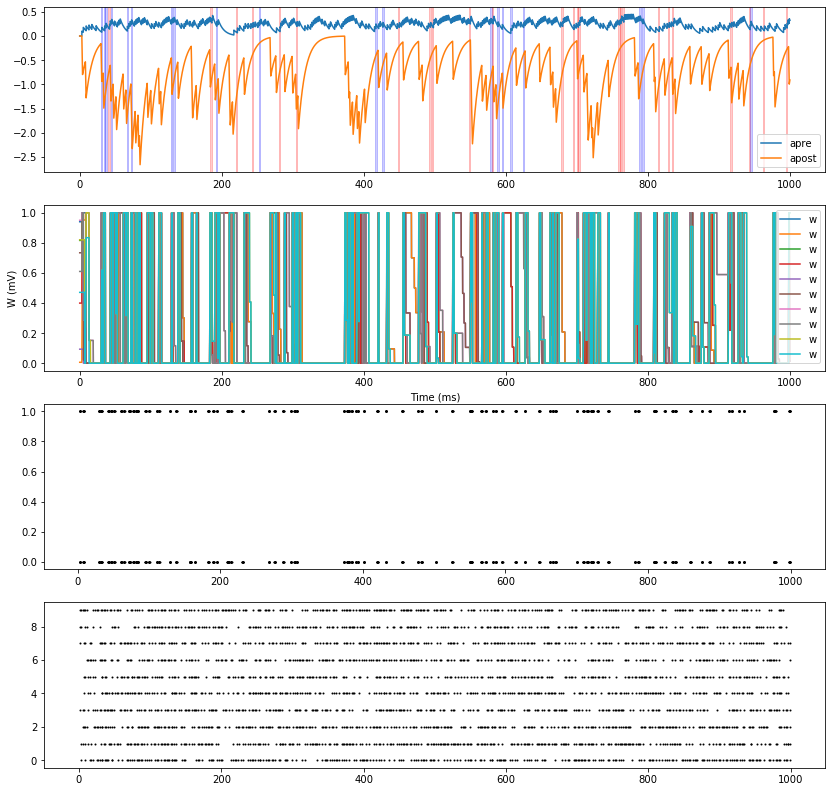

In [26]:
figure(figsize=(14, 14))
subplot(411)
plot(M.t/ms, M.apre[2], label='apre')
plot(M.t/ms, M.apost[2], label='apost')
for i in range (len(pattern_time)):
    if which_pattern[i] == 0:
        axvspan(pattern_time[i] , pattern_time[i]+2, alpha=0.2, color='red')
    else:
        axvspan(pattern_time[i] , pattern_time[i]+2, alpha=0.2, color='blue')
legend()
subplot(412)
for i in range(10):
    plot(M.t/ms, M.w[i], label='w')
legend(loc='best')
xlabel('Time (ms)')
ylabel('W (mV)')
subplot(413)
plot(s1.t/ms, s1.i, 'ok', ms=1)
subplot(414)
plot(s2.t/ms, s2.i, 'ok', ms=1)

In [244]:
pattern_time

[2, 26, 48, 78, 88, 96]

In [185]:
which_neuron[1]

1

In [186]:
spike_time[1]

2. * msecond

In [211]:
sorted([x/ms for x in list(s3.all_values()['t'][4])])

[2.0,
 3.0,
 5.0,
 8.0,
 10.0,
 12.0,
 13.0,
 15.0,
 17.0,
 19.0,
 21.0,
 23.0,
 26.0,
 28.0,
 30.0,
 31.0,
 33.0,
 35.0,
 37.00000000000001,
 39.0,
 41.0,
 43.0,
 46.0,
 47.0,
 50.0,
 51.0,
 53.00000000000001,
 55.0,
 57.0,
 60.0,
 62.0,
 63.0,
 65.0,
 67.0,
 69.0,
 72.0,
 73.00000000000001,
 75.0,
 78.0,
 79.0,
 82.0,
 83.0,
 86.0,
 87.0,
 90.00000000000001,
 92.0,
 93.0,
 95.0,
 98.0,
 99.0,
 101.0,
 103.0,
 106.00000000000001,
 108.0,
 110.0,
 112.0,
 114.0,
 116.0,
 118.0,
 119.0,
 122.00000000000001,
 123.00000000000001,
 125.0,
 127.0,
 129.0,
 131.0,
 133.0,
 135.0,
 137.0,
 139.0,
 141.0,
 144.0,
 146.00000000000003,
 148.00000000000003,
 149.0,
 152.0,
 154.0,
 156.0,
 157.0,
 160.0,
 161.0,
 163.0,
 165.0,
 167.0,
 169.0,
 171.0,
 173.0,
 175.0,
 177.00000000000003,
 180.00000000000003,
 182.0,
 183.0,
 186.0,
 187.0,
 189.0,
 191.0,
 193.0,
 195.0,
 197.0,
 200.0,
 202.0,
 203.0,
 205.0,
 207.0,
 210.00000000000003,
 211.00000000000003,
 213.00000000000003,
 216.0,
 218.0,


In [137]:
M.w[20][-1]

IndexError: index 20 is out of bounds for axis 0 with size 20

In [57]:
s2.all_values()

{'t': {0: array([ 1. , 33.8, 33.9, 34. , 34.1, 34.2, 34.3, 34.4, 34.5, 34.6, 34.7,
         34.8, 34.9, 35. , 35.1, 35.2, 35.3, 35.4, 33.7, 35.5, 33.6, 33.4,
         24.7, 24.8, 24.9, 25. , 25.1, 25.2, 25.3, 25.4, 25.5, 25.6, 25.7,
         25.8, 25.9, 33. , 33.1, 33.2, 33.3, 33.5, 35.6, 35.7, 35.8, 48.1,
         48.2, 48.3, 48.4, 48.5, 48.6, 48.7, 48.8, 48.9, 49. , 49.1, 49.2,
         49.3, 49.4, 49.5, 49.6, 49.7, 48. , 47.9, 47.8, 47.7, 35.9, 36. ,
         36.1, 36.2, 36.3, 36.4, 36.5, 36.6, 24.6, 36.7, 36.9, 47. , 47.1,
         47.2, 47.3, 47.4, 47.5, 47.6, 36.8, 24.5, 24.4, 24.3,  4.3,  4.4,
          4.5,  4.6,  4.7,  4.8,  4.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,
          7.6,  7.7,  7.8,  7.9,  4.2,  4.1,  4. ,  2.9,  1.1,  1.2,  1.3,
          1.4,  1.5,  1.6,  1.7,  1.8, 17. ,  1.9,  2.1,  2.2,  2.3,  2.4,
          2.5,  2.6,  2.7,  2.8,  2. , 49.8, 17.1, 17.3, 21.6, 21.7, 21.8,
         21.9, 22. , 22.1, 22.2, 22.3, 22.4, 22.5, 22.6, 22.7, 22.8, 22.9,
         24. , 24

In [10]:
duration = 100
l = 5
ls = []
for i in range(int(100/5)):
    base = i * 5
    choice = np.random.choice([0,1],p=[0.7,0.3])
    if choice == 0:
        ls.append(base+randrange(1,5))
        print('0 - ',base,' - ',ls[-1])
    if choice == 1:
        ls.append(base+3)
        print('1 - ',base,' - ',ls[-1])
print(ls)
    

1 -  0  -  3
0 -  5  -  7
0 -  10  -  11
0 -  15  -  18
0 -  20  -  22
1 -  25  -  28
1 -  30  -  33
0 -  35  -  39
0 -  40  -  41
0 -  45  -  46
1 -  50  -  53
1 -  55  -  58
1 -  60  -  63
1 -  65  -  68
0 -  70  -  72
1 -  75  -  78
0 -  80  -  84
0 -  85  -  87
1 -  90  -  93
0 -  95  -  97
[3, 7, 11, 18, 22, 28, 33, 39, 41, 46, 53, 58, 63, 68, 72, 78, 84, 87, 93, 97]


In [17]:
# runtime = 5*ms
G = SpikeGeneratorGroup(1, [0]*len(ls), [i*ms for i in ls])
spike_mon = SpikeMonitor(G)
run(100*ms)

WARNING    "spikemonitor" has been included in the network but not the object on which it depends.Setting "spikemonitor" to inactive. [brian2.core.magic.dependency_warning]


In [18]:
spike_mon.t

<spikemonitor_1.t: array([ 3.,  7., 11., 18., 22., 28., 33., 39., 41., 46., 53., 58., 63.,
       68., 72., 78., 84., 87., 93., 97.]) * msecond>

In [7]:
runtime = 3*ms
G = SpikeGeneratorGroup(1, [0], [1*ms])
spike_mon = SpikeMonitor(G)
for i in range(10):
    run(3*ms)
    choice = np.random.choice([0,1],p=[0.2,0.8])
    if choice == 0:
        G.set_spikes(spike_mon.i, spike_mon.t + runtime)
    G.set_spikes(spike_mon.i, spike_mon.t + runtime)
    print(spike_mon.t)
    print(spike_mon.i)

WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 6. ms), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]


<spikemonitor.t: array([1.]) * msecond>
<spikemonitor.i: array([0])>
<spikemonitor.t: array([1., 4.]) * msecond>
<spikemonitor.i: array([0, 0])>


WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 9. ms), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 12. ms), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]


<spikemonitor.t: array([1., 4., 7.]) * msecond>
<spikemonitor.i: array([0, 0, 0])>
<spikemonitor.t: array([ 1.,  4.,  7., 10.]) * msecond>
<spikemonitor.i: array([0, 0, 0, 0])>
<spikemonitor.t: array([ 1.,  4.,  7., 10., 13.]) * msecond>
<spikemonitor.i: array([0, 0, 0, 0, 0])>


WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 15. ms), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 18. ms), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 21. ms), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]


<spikemonitor.t: array([ 1.,  4.,  7., 10., 13., 16.]) * msecond>
<spikemonitor.i: array([0, 0, 0, 0, 0, 0])>
<spikemonitor.t: array([ 1.,  4.,  7., 10., 13., 16., 19.]) * msecond>
<spikemonitor.i: array([0, 0, 0, 0, 0, 0, 0])>


WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 24. ms), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]
WARNING    The SpikeGeneratorGroup contains spike times earlier than the start time of the current run (t = 27. ms), these spikes will be ignored. [brian2.input.spikegeneratorgroup.ignored_spikes]


<spikemonitor.t: array([ 1.,  4.,  7., 10., 13., 16., 19., 22.]) * msecond>
<spikemonitor.i: array([0, 0, 0, 0, 0, 0, 0, 0])>
<spikemonitor.t: array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25.]) * msecond>
<spikemonitor.i: array([0, 0, 0, 0, 0, 0, 0, 0, 0])>
<spikemonitor.t: array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28.]) * msecond>
<spikemonitor.i: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>


In [16]:
G.get_states

<bound method VariableOwner.get_states of SpikeGeneratorGroup(1, indices=<length 0 array>, times=<length 0 array>>

In [ ]:
def make_noise_pattern_current(pattern , delta_time , duration , possibility):
    